In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 50

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -500
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 100  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 40 #10
NEGATIVE_REWARD_DIVIDE = 40 # kolikrat bude mensi times factor pri zaporne odmene

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0 # exploration rate
        self.epsilon_min = 0.0
        self.epsilon_decay = 0.9996
        
        self.learning_rate = 0.001
        self.learning_rate_decay = 0.99999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))

        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0 #0.00001
    NEGATIVE_TIMES_REWARD = 0 #0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
            
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
                
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
More than 80 on candle 504
More than 80 on candle 1772


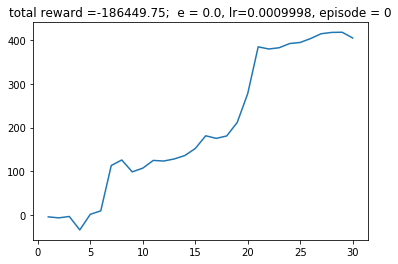

Waiting to train the whole dataset
action0:  401 
action1:  661 
action2:  888
DONE, lets roll!!
222.351
More than 80 on candle 1766


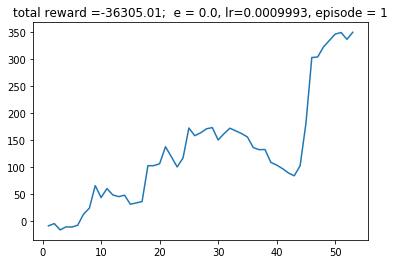

Waiting to train the whole dataset
action0:  103 
action1:  671 
action2:  1176
DONE, lets roll!!
325.534
More than 80 on candle 1783


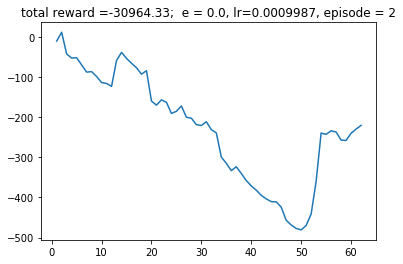

Waiting to train the whole dataset
action0:  83 
action1:  742 
action2:  1125
DONE, lets roll!!
346.011
More than 80 on candle 1742


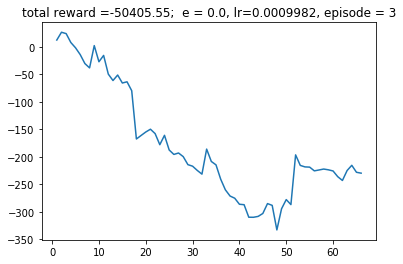

Waiting to train the whole dataset
action0:  113 
action1:  663 
action2:  1174
DONE, lets roll!!
337.41
More than 80 on candle 1776


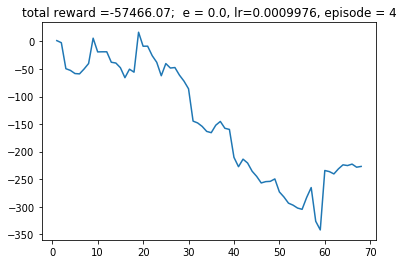

Waiting to train the whole dataset
action0:  130 
action1:  758 
action2:  1062
DONE, lets roll!!
341.808
More than 80 on candle 1783


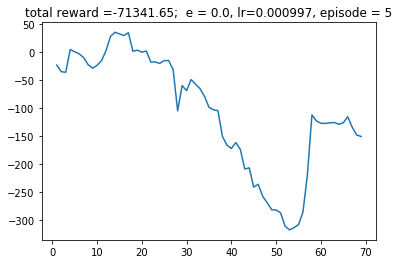

Waiting to train the whole dataset
action0:  176 
action1:  755 
action2:  1019
DONE, lets roll!!
338.804
More than 80 on candle 1761


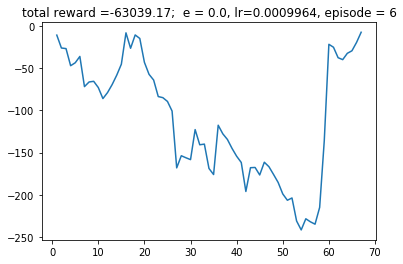

Waiting to train the whole dataset
action0:  163 
action1:  858 
action2:  929
DONE, lets roll!!
348.762
More than 80 on candle 511
More than 80 on candle 1685


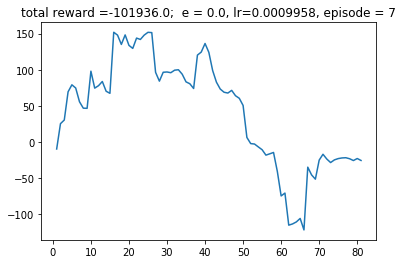

Waiting to train the whole dataset
action0:  251 
action1:  644 
action2:  1055
DONE, lets roll!!
342.914
More than 80 on candle 1742


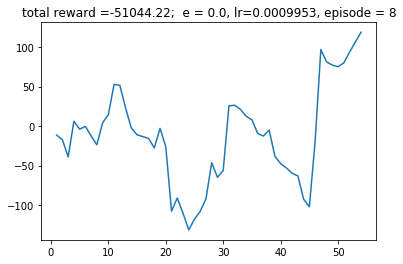

Waiting to train the whole dataset
action0:  144 
action1:  758 
action2:  1048
DONE, lets roll!!
339.631
More than 80 on candle 1765


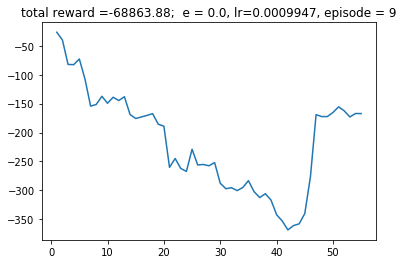

Waiting to train the whole dataset
action0:  155 
action1:  647 
action2:  1148
DONE, lets roll!!
344.246
More than 80 on candle 511
More than 80 on candle 880
More than 80 on candle 1667


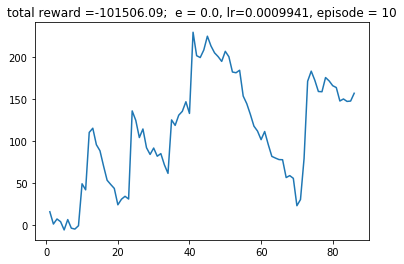

Waiting to train the whole dataset
action0:  278 
action1:  658 
action2:  1014
DONE, lets roll!!
351.151
More than 80 on candle 1781


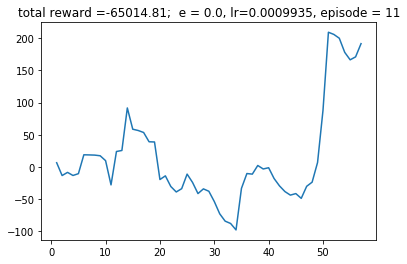

Waiting to train the whole dataset
action0:  178 
action1:  682 
action2:  1090
DONE, lets roll!!
411.232
More than 80 on candle 1772


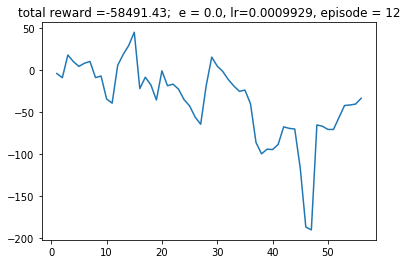

Waiting to train the whole dataset
action0:  146 
action1:  682 
action2:  1122
DONE, lets roll!!
357.018
More than 80 on candle 1739


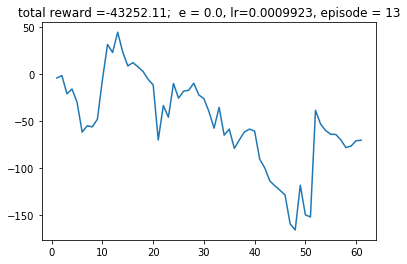

Waiting to train the whole dataset
action0:  105 
action1:  727 
action2:  1118
DONE, lets roll!!
350.409
More than 80 on candle 301
More than 80 on candle 1748


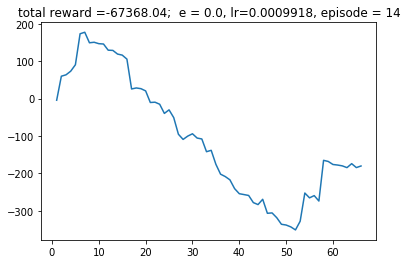

Waiting to train the whole dataset
action0:  168 
action1:  624 
action2:  1158
DONE, lets roll!!
351.953
More than 80 on candle 492
More than 80 on candle 1734


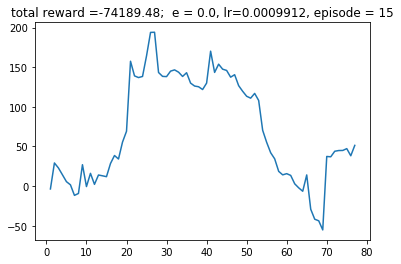

Waiting to train the whole dataset
action0:  194 
action1:  674 
action2:  1082
DONE, lets roll!!
355.815
More than 80 on candle 1788


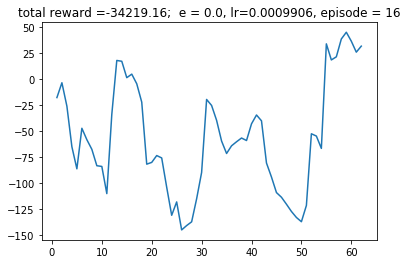

Waiting to train the whole dataset
action0:  98 
action1:  822 
action2:  1030
DONE, lets roll!!
352.024
More than 80 on candle 1748


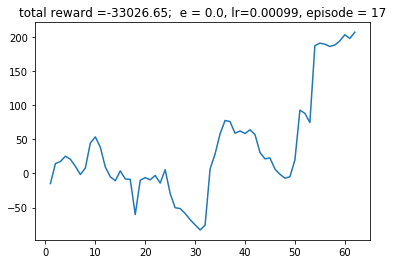

Waiting to train the whole dataset
action0:  103 
action1:  614 
action2:  1233
DONE, lets roll!!
351.134
More than 80 on candle 1762


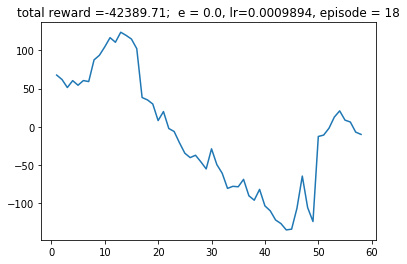

Waiting to train the whole dataset
action0:  103 
action1:  654 
action2:  1193
DONE, lets roll!!
356.909
More than 80 on candle 1741


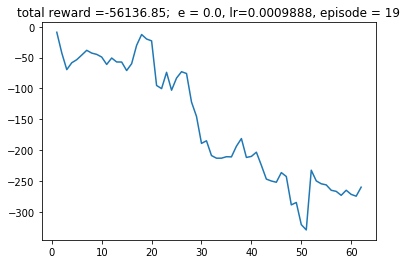

Waiting to train the whole dataset
action0:  125 
action1:  701 
action2:  1124
DONE, lets roll!!
355.797
More than 80 on candle 1779


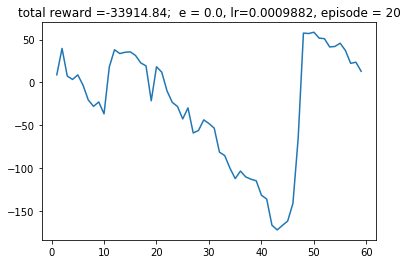

Waiting to train the whole dataset
action0:  86 
action1:  709 
action2:  1155
DONE, lets roll!!
350.581
More than 80 on candle 1739


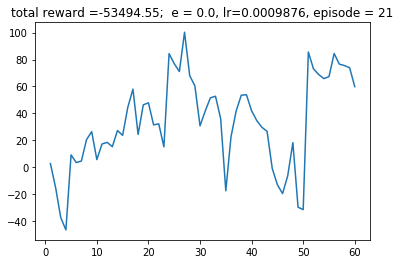

Waiting to train the whole dataset
action0:  136 
action1:  606 
action2:  1208
DONE, lets roll!!
350.728
More than 80 on candle 514
More than 80 on candle 1738


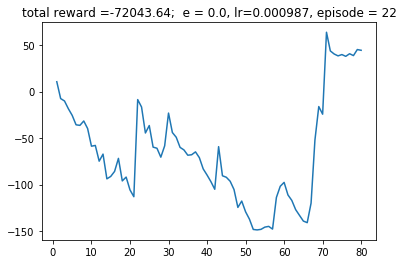

Waiting to train the whole dataset
action0:  190 
action1:  776 
action2:  984
DONE, lets roll!!
356.058
More than 80 on candle 1800


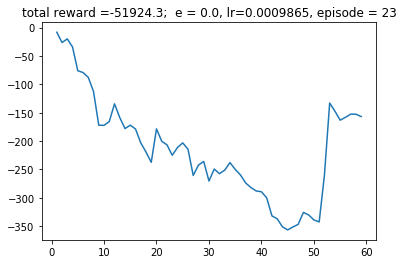

Waiting to train the whole dataset
action0:  129 
action1:  673 
action2:  1148
DONE, lets roll!!
353.393
More than 80 on candle 1774


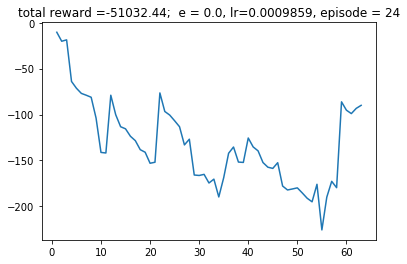

Waiting to train the whole dataset
action0:  122 
action1:  571 
action2:  1257
DONE, lets roll!!
351.865
More than 80 on candle 1768


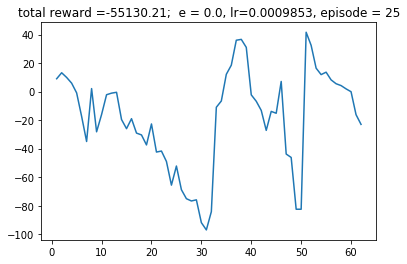

Waiting to train the whole dataset
action0:  137 
action1:  567 
action2:  1246
DONE, lets roll!!
348.336
More than 80 on candle 1853


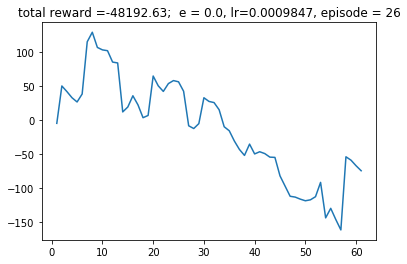

Waiting to train the whole dataset
action0:  122 
action1:  643 
action2:  1185
DONE, lets roll!!
347.645
More than 80 on candle 1773


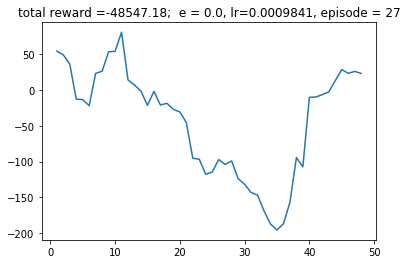

Waiting to train the whole dataset
action0:  122 
action1:  740 
action2:  1088
DONE, lets roll!!
351.332
More than 80 on candle 1778


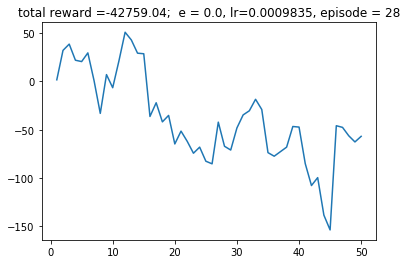

Waiting to train the whole dataset
action0:  108 
action1:  665 
action2:  1177
DONE, lets roll!!
351.765
More than 80 on candle 319
More than 80 on candle 1773


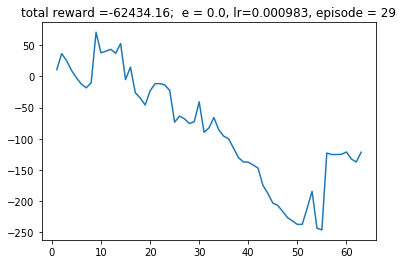

Waiting to train the whole dataset
action0:  162 
action1:  593 
action2:  1195
DONE, lets roll!!
355.911
More than 80 on candle 1780


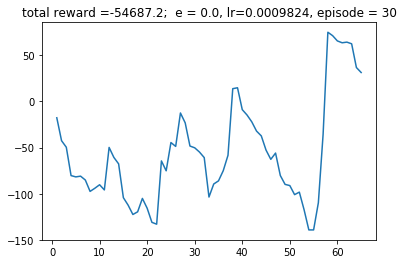

Waiting to train the whole dataset
action0:  147 
action1:  762 
action2:  1041
DONE, lets roll!!
353.972
More than 80 on candle 511
More than 80 on candle 1741


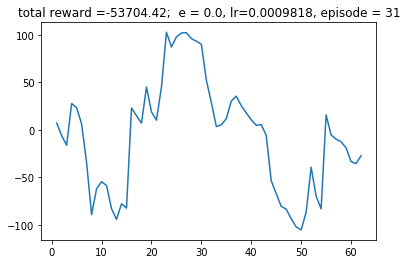

Waiting to train the whole dataset
action0:  149 
action1:  610 
action2:  1191
DONE, lets roll!!
349.558
More than 80 on candle 1766


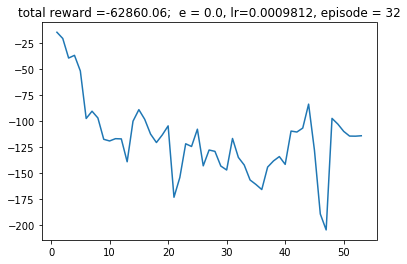

Waiting to train the whole dataset
action0:  151 
action1:  756 
action2:  1043
DONE, lets roll!!
344.999
More than 80 on candle 876
More than 80 on candle 1685


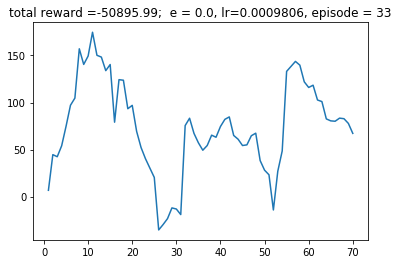

Waiting to train the whole dataset
action0:  139 
action1:  887 
action2:  924
DONE, lets roll!!
351.34
More than 80 on candle 1777


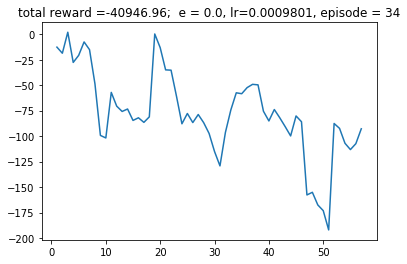

Waiting to train the whole dataset
action0:  102 
action1:  670 
action2:  1178
DONE, lets roll!!
348.254
More than 80 on candle 1795


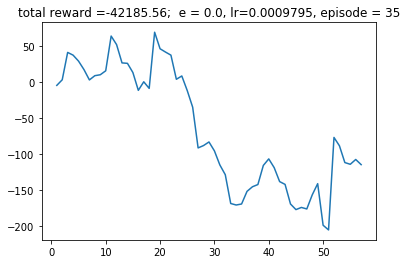

Waiting to train the whole dataset
action0:  108 
action1:  560 
action2:  1282
DONE, lets roll!!
345.635
More than 80 on candle 1787


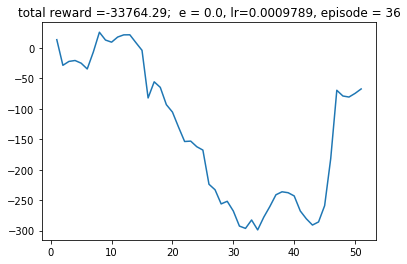

Waiting to train the whole dataset
action0:  83 
action1:  632 
action2:  1235
DONE, lets roll!!
353.626
More than 80 on candle 1776


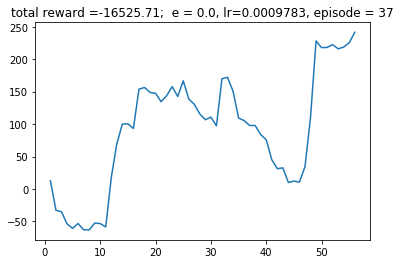

Waiting to train the whole dataset
action0:  70 
action1:  684 
action2:  1196
DONE, lets roll!!
358.659
More than 80 on candle 1793


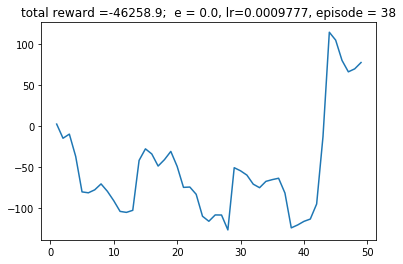

Waiting to train the whole dataset
action0:  115 
action1:  730 
action2:  1105
DONE, lets roll!!
416.133
More than 80 on candle 1580


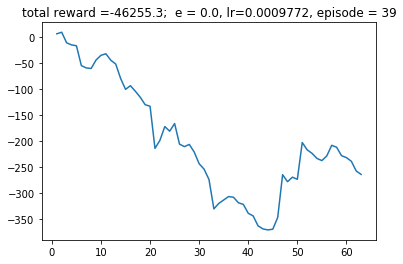

Waiting to train the whole dataset
action0:  95 
action1:  682 
action2:  1173
DONE, lets roll!!
348.724
More than 80 on candle 1805


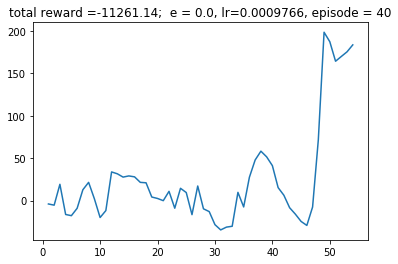

Waiting to train the whole dataset
action0:  46 
action1:  641 
action2:  1263
DONE, lets roll!!
349.079
More than 80 on candle 1788


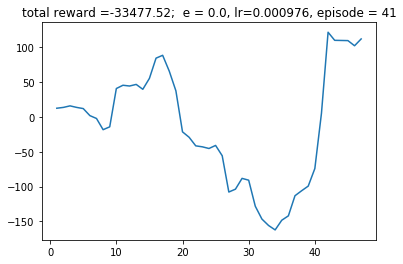

Waiting to train the whole dataset
action0:  91 
action1:  652 
action2:  1207
DONE, lets roll!!
354.061
More than 80 on candle 1784


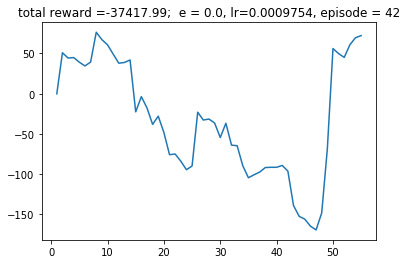

Waiting to train the whole dataset
action0:  99 
action1:  643 
action2:  1208
DONE, lets roll!!
349.83
More than 80 on candle 1783


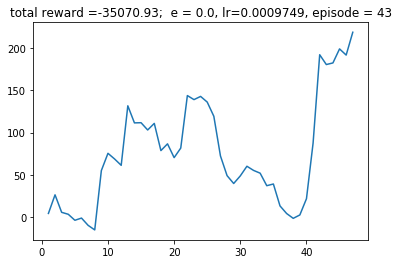

Waiting to train the whole dataset
action0:  108 
action1:  818 
action2:  1024
DONE, lets roll!!
354.057
More than 80 on candle 546
More than 80 on candle 1558
More than 80 on candle 1684


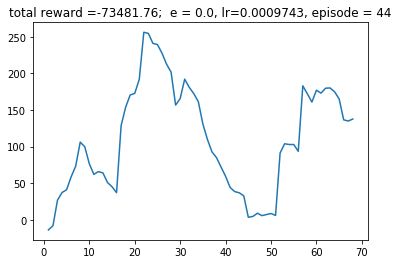

Waiting to train the whole dataset
action0:  200 
action1:  712 
action2:  1038
DONE, lets roll!!
354.264
More than 80 on candle 1741


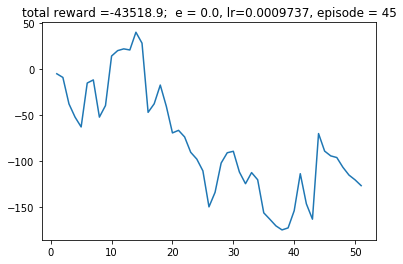

Waiting to train the whole dataset
action0:  104 
action1:  525 
action2:  1321
DONE, lets roll!!
354.817
More than 80 on candle 1793


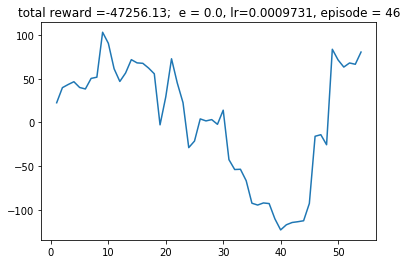

Waiting to train the whole dataset
action0:  129 
action1:  678 
action2:  1143
DONE, lets roll!!
350.647
More than 80 on candle 1800


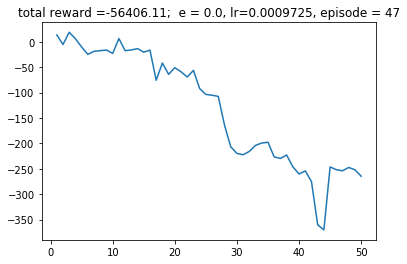

Waiting to train the whole dataset
action0:  117 
action1:  546 
action2:  1287
DONE, lets roll!!
360.495
More than 80 on candle 1795


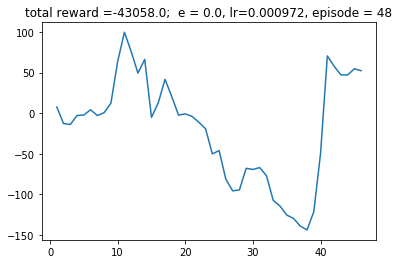

Waiting to train the whole dataset
action0:  106 
action1:  591 
action2:  1253
DONE, lets roll!!
349.16
More than 80 on candle 486
More than 80 on candle 1741


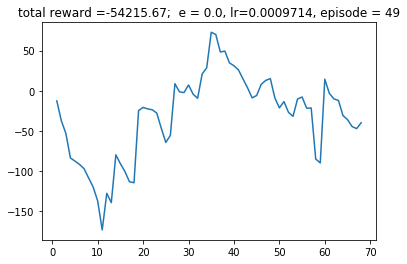

Waiting to train the whole dataset
action0:  146 
action1:  666 
action2:  1138
DONE, lets roll!!
353.003
More than 80 on candle 1797


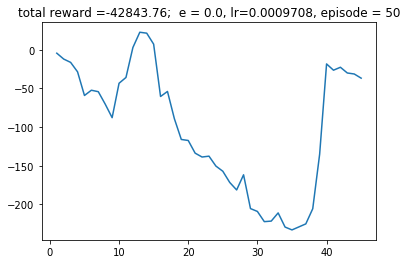

Waiting to train the whole dataset
action0:  100 
action1:  657 
action2:  1193
DONE, lets roll!!
352.775
More than 80 on candle 1800


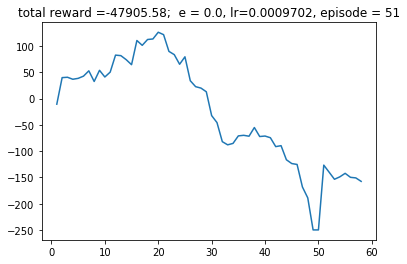

Waiting to train the whole dataset
action0:  104 
action1:  621 
action2:  1225
DONE, lets roll!!
356.095
More than 80 on candle 1787


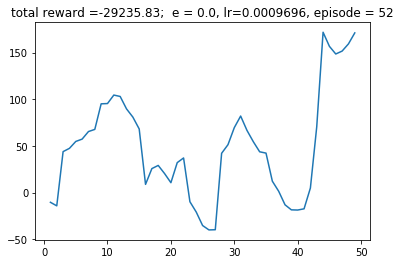

Waiting to train the whole dataset
action0:  87 
action1:  736 
action2:  1127
DONE, lets roll!!
349.241
More than 80 on candle 502
More than 80 on candle 1785


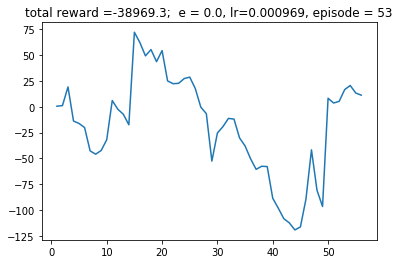

Waiting to train the whole dataset
action0:  98 
action1:  632 
action2:  1220
DONE, lets roll!!
362.285
More than 80 on candle 1795


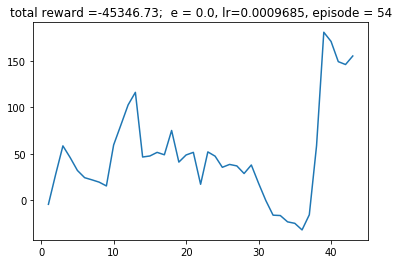

Waiting to train the whole dataset
action0:  111 
action1:  591 
action2:  1248
DONE, lets roll!!
350.702
More than 80 on candle 1788


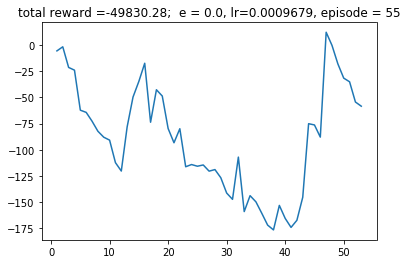

Waiting to train the whole dataset
action0:  119 
action1:  812 
action2:  1019
DONE, lets roll!!
347.919
More than 80 on candle 1797


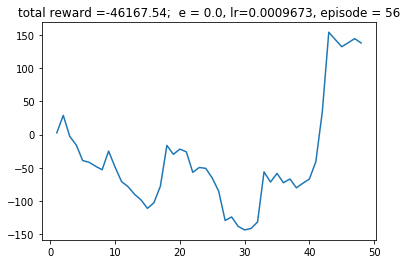

Waiting to train the whole dataset
action0:  124 
action1:  761 
action2:  1065
DONE, lets roll!!
356.713
More than 80 on candle 1801


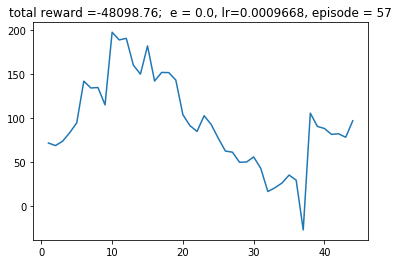

Waiting to train the whole dataset
action0:  127 
action1:  506 
action2:  1317
DONE, lets roll!!
353.545
More than 80 on candle 881
More than 80 on candle 1769


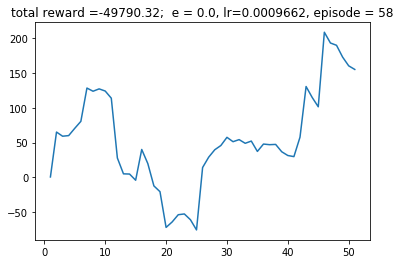

Waiting to train the whole dataset
action0:  138 
action1:  798 
action2:  1014
DONE, lets roll!!
351.586
More than 80 on candle 511
More than 80 on candle 1786


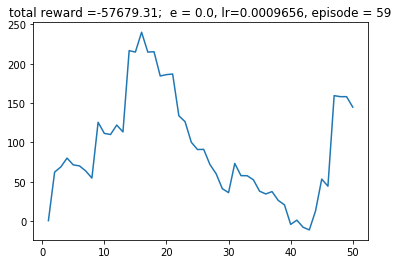

Waiting to train the whole dataset
action0:  152 
action1:  582 
action2:  1216
DONE, lets roll!!
354.019
More than 80 on candle 1824


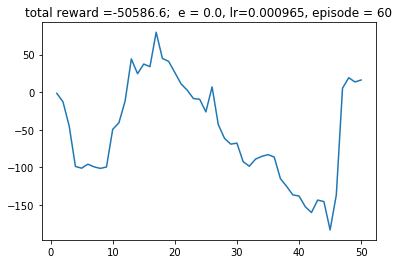

Waiting to train the whole dataset
action0:  129 
action1:  539 
action2:  1282
DONE, lets roll!!
350.273
More than 80 on candle 1791


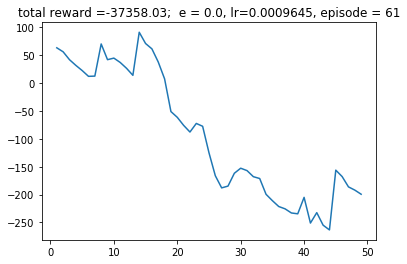

Waiting to train the whole dataset
action0:  88 
action1:  499 
action2:  1363
DONE, lets roll!!
354.776
More than 80 on candle 1559


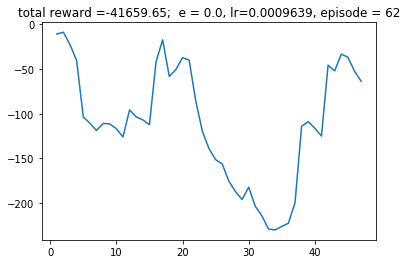

Waiting to train the whole dataset
action0:  99 
action1:  682 
action2:  1169
DONE, lets roll!!
354.811
More than 80 on candle 1845


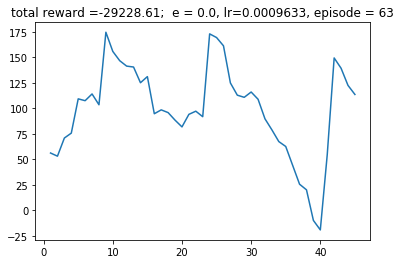

Waiting to train the whole dataset
action0:  78 
action1:  641 
action2:  1231
DONE, lets roll!!
352.536
More than 80 on candle 509
More than 80 on candle 1763


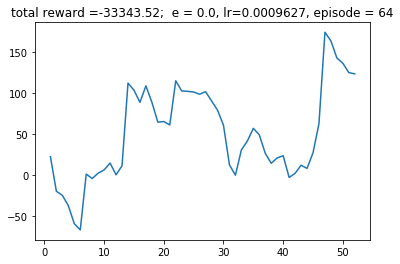

Waiting to train the whole dataset
action0:  102 
action1:  708 
action2:  1140
DONE, lets roll!!
354.594
More than 80 on candle 524
More than 80 on candle 1785


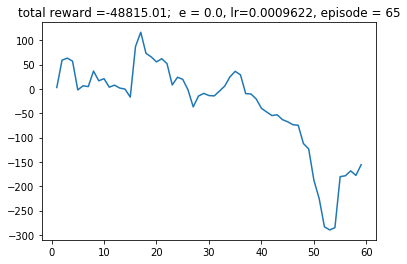

Waiting to train the whole dataset
action0:  123 
action1:  536 
action2:  1291
DONE, lets roll!!
349.735
More than 80 on candle 1797


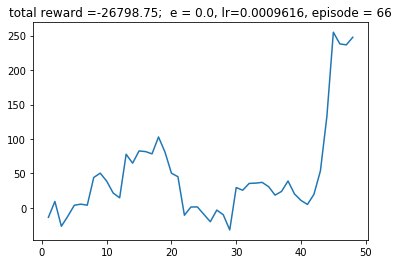

Waiting to train the whole dataset
action0:  83 
action1:  716 
action2:  1151
DONE, lets roll!!
350.712
More than 80 on candle 1851


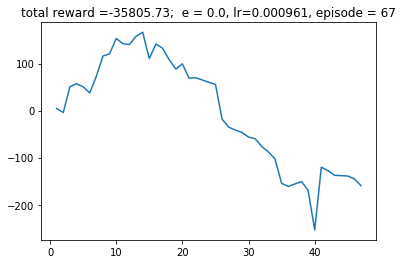

Waiting to train the whole dataset
action0:  82 
action1:  581 
action2:  1287
DONE, lets roll!!
357.136
More than 80 on candle 512
More than 80 on candle 876
More than 80 on candle 1575
More than 80 on candle 1732


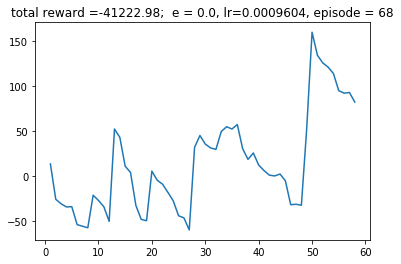

Waiting to train the whole dataset
action0:  121 
action1:  762 
action2:  1067
DONE, lets roll!!
354.719
More than 80 on candle 1798


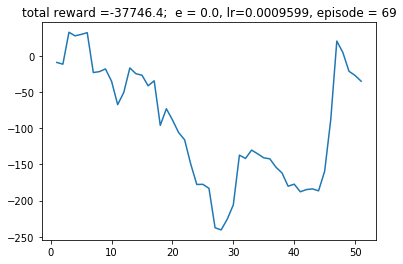

Waiting to train the whole dataset
action0:  97 
action1:  940 
action2:  913
DONE, lets roll!!
356.331
More than 80 on candle 1832


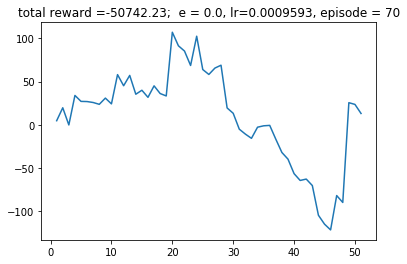

Waiting to train the whole dataset
action0:  120 
action1:  706 
action2:  1124
DONE, lets roll!!
347.962
More than 80 on candle 1772


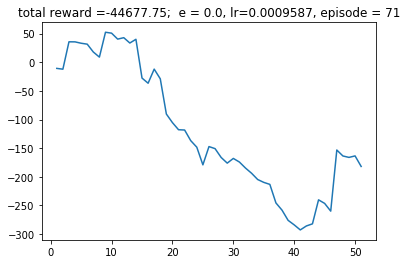

Waiting to train the whole dataset
action0:  89 
action1:  601 
action2:  1260
DONE, lets roll!!
364.265
More than 80 on candle 1784


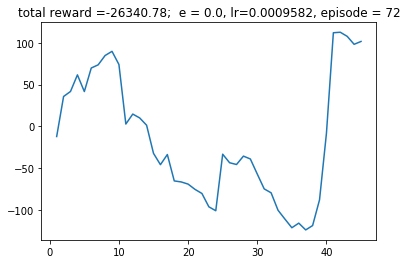

Waiting to train the whole dataset
action0:  71 
action1:  683 
action2:  1196
DONE, lets roll!!
357.117
More than 80 on candle 1791


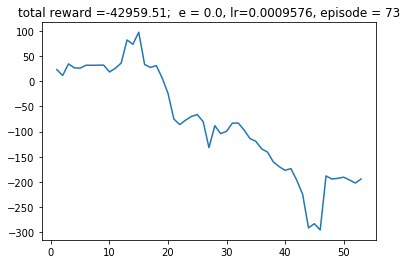

Waiting to train the whole dataset
action0:  96 
action1:  617 
action2:  1237
DONE, lets roll!!
352.345
More than 80 on candle 877
More than 80 on candle 1763


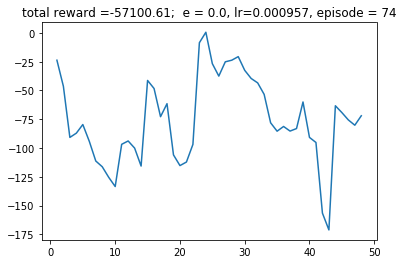

Waiting to train the whole dataset
action0:  137 
action1:  453 
action2:  1360
DONE, lets roll!!
355.341
More than 80 on candle 492
More than 80 on candle 1590
More than 80 on candle 1722


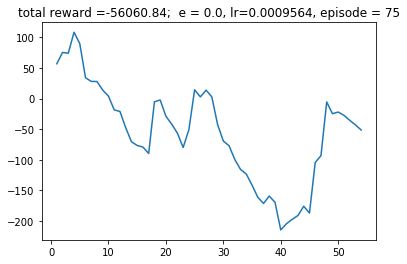

Waiting to train the whole dataset
action0:  152 
action1:  709 
action2:  1089
DONE, lets roll!!
359.074
More than 80 on candle 510
More than 80 on candle 1776


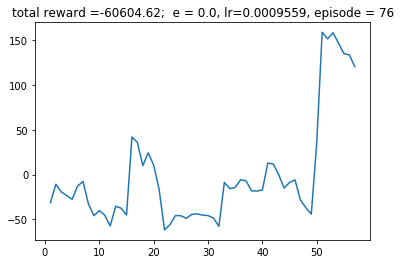

Waiting to train the whole dataset
action0:  157 
action1:  745 
action2:  1048
DONE, lets roll!!
344.723
More than 80 on candle 1796


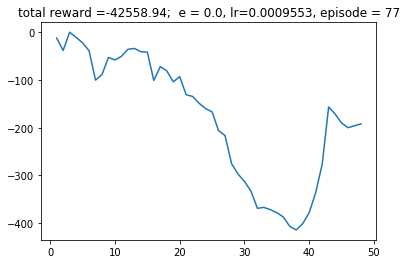

Waiting to train the whole dataset
action0:  96 
action1:  606 
action2:  1248
DONE, lets roll!!
349.166
More than 80 on candle 523
More than 80 on candle 1743


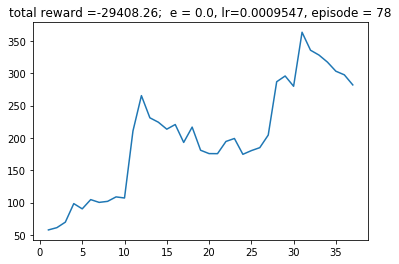

Waiting to train the whole dataset
action0:  87 
action1:  566 
action2:  1297
DONE, lets roll!!
359.011
More than 80 on candle 1784


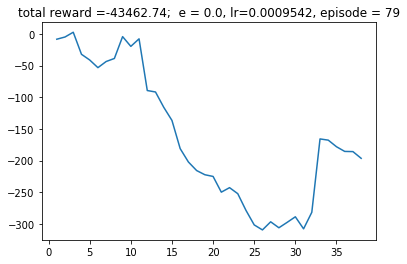

Waiting to train the whole dataset
action0:  80 
action1:  506 
action2:  1364
DONE, lets roll!!
357.756
More than 80 on candle 1791


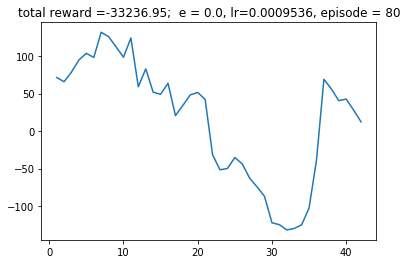

Waiting to train the whole dataset
action0:  85 
action1:  604 
action2:  1261
DONE, lets roll!!
352.192
More than 80 on candle 513
More than 80 on candle 1776


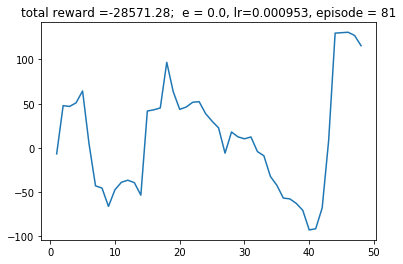

Waiting to train the whole dataset
action0:  87 
action1:  631 
action2:  1232
DONE, lets roll!!
355.334
More than 80 on candle 513
More than 80 on candle 1557
More than 80 on candle 1731


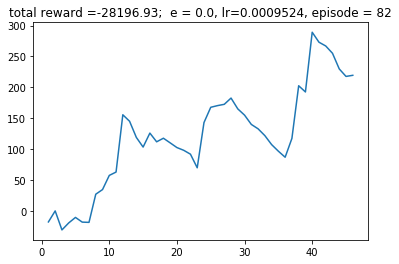

Waiting to train the whole dataset
action0:  84 
action1:  666 
action2:  1200
DONE, lets roll!!
360.561
More than 80 on candle 1842


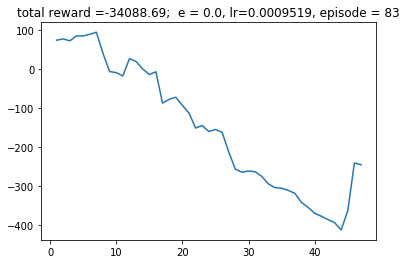

Waiting to train the whole dataset
action0:  74 
action1:  401 
action2:  1475
DONE, lets roll!!
355.631
More than 80 on candle 1810


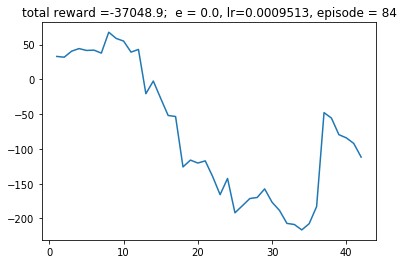

Waiting to train the whole dataset
action0:  82 
action1:  474 
action2:  1394
DONE, lets roll!!
351.56
More than 80 on candle 915
More than 80 on candle 1747


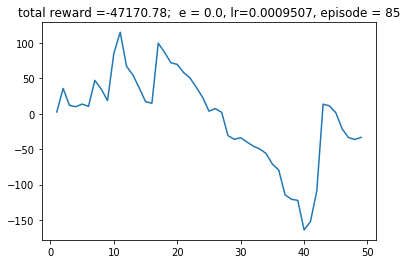

Waiting to train the whole dataset
action0:  118 
action1:  640 
action2:  1192
DONE, lets roll!!
351.161
More than 80 on candle 543
More than 80 on candle 1792


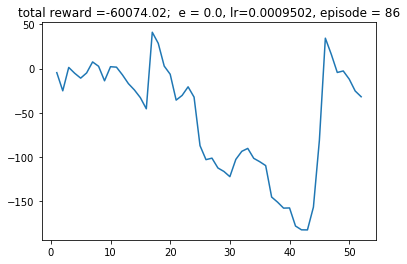

Waiting to train the whole dataset
action0:  148 
action1:  783 
action2:  1019
DONE, lets roll!!
355.032
More than 80 on candle 1810


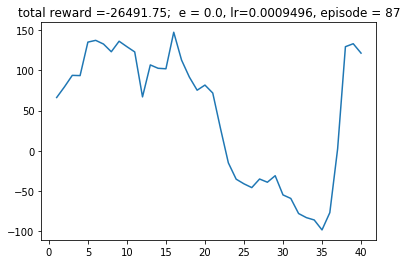

Waiting to train the whole dataset
action0:  73 
action1:  567 
action2:  1310
DONE, lets roll!!
359.932
More than 80 on candle 523
More than 80 on candle 1782


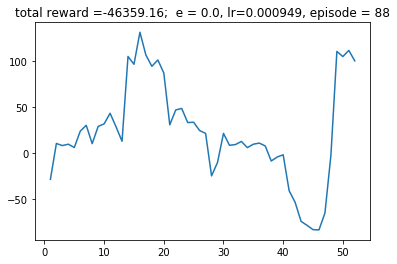

Waiting to train the whole dataset
action0:  123 
action1:  739 
action2:  1088
DONE, lets roll!!
357.677
More than 80 on candle 1841


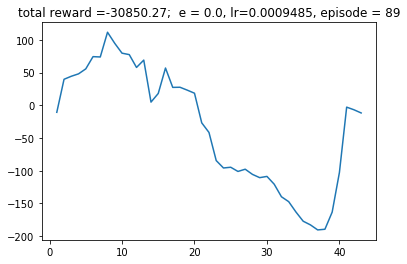

Waiting to train the whole dataset
action0:  65 
action1:  567 
action2:  1318
DONE, lets roll!!
344.978
More than 80 on candle 488
More than 80 on candle 1772


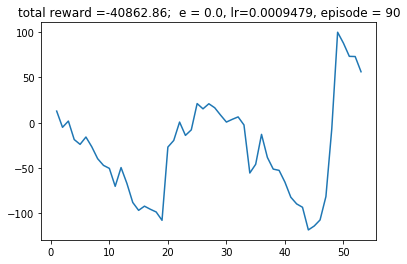

Waiting to train the whole dataset
action0:  107 
action1:  593 
action2:  1250
DONE, lets roll!!
357.665
More than 80 on candle 1833


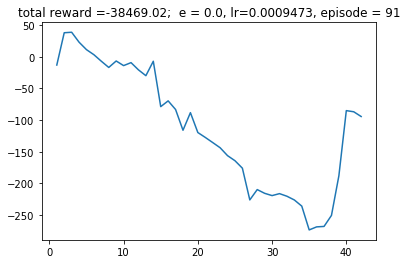

Waiting to train the whole dataset
action0:  74 
action1:  602 
action2:  1274
DONE, lets roll!!
355.246
More than 80 on candle 1780


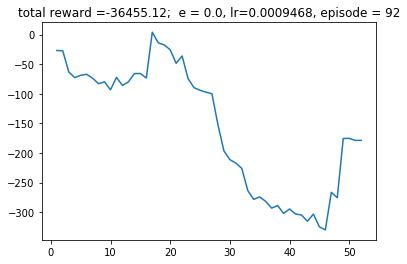

Waiting to train the whole dataset
action0:  72 
action1:  719 
action2:  1159
DONE, lets roll!!
356.492
More than 80 on candle 1822


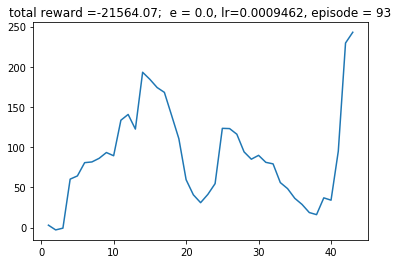

Waiting to train the whole dataset
action0:  67 
action1:  692 
action2:  1191
DONE, lets roll!!
353.05
More than 80 on candle 514
More than 80 on candle 1746


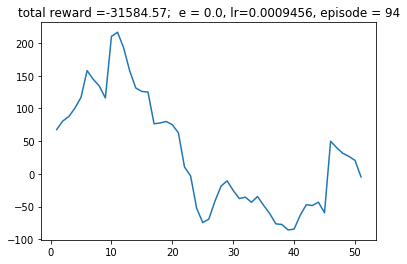

Waiting to train the whole dataset
action0:  84 
action1:  704 
action2:  1162
DONE, lets roll!!
350.825
More than 80 on candle 1808


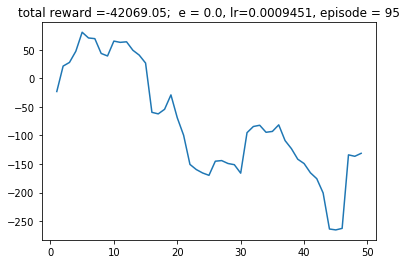

Waiting to train the whole dataset
action0:  98 
action1:  603 
action2:  1249
DONE, lets roll!!
349.553
More than 80 on candle 1813


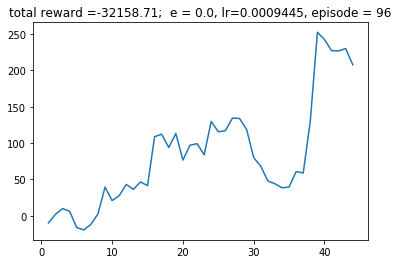

Waiting to train the whole dataset
action0:  89 
action1:  698 
action2:  1163
DONE, lets roll!!
348.748
More than 80 on candle 1845


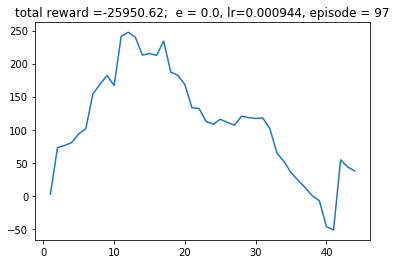

Waiting to train the whole dataset
action0:  58 
action1:  454 
action2:  1438
DONE, lets roll!!
347.314
More than 80 on candle 1785


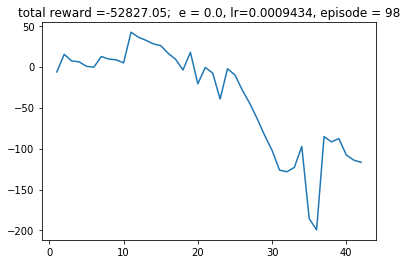

Waiting to train the whole dataset
action0:  109 
action1:  415 
action2:  1426
DONE, lets roll!!
347.333
More than 80 on candle 524
More than 80 on candle 1800


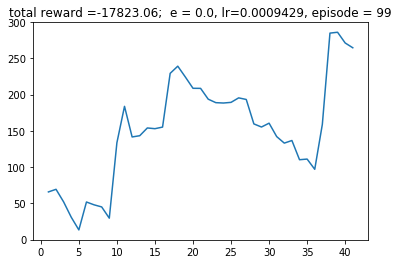

Waiting to train the whole dataset
action0:  62 
action1:  520 
action2:  1368
DONE, lets roll!!
357.695
More than 80 on candle 512
More than 80 on candle 1789


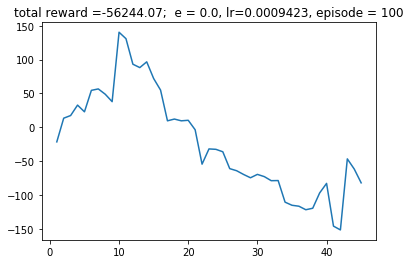

Waiting to train the whole dataset
action0:  127 
action1:  574 
action2:  1249
DONE, lets roll!!
352.729
More than 80 on candle 542
More than 80 on candle 1739


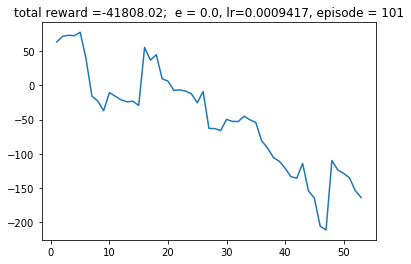

Waiting to train the whole dataset
action0:  88 
action1:  444 
action2:  1418
DONE, lets roll!!
349.799
More than 80 on candle 1794


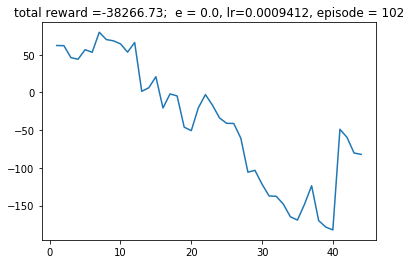

Waiting to train the whole dataset
action0:  92 
action1:  575 
action2:  1283
DONE, lets roll!!
350.2
More than 80 on candle 1783


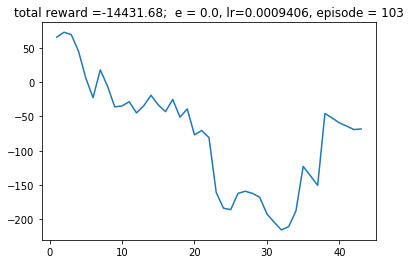

Waiting to train the whole dataset
action0:  24 
action1:  589 
action2:  1337
DONE, lets roll!!
416.459
More than 80 on candle 1811


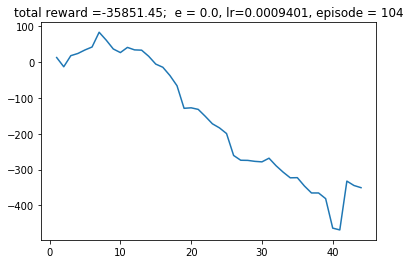

Waiting to train the whole dataset
action0:  65 
action1:  580 
action2:  1305
DONE, lets roll!!
347.533
More than 80 on candle 1806


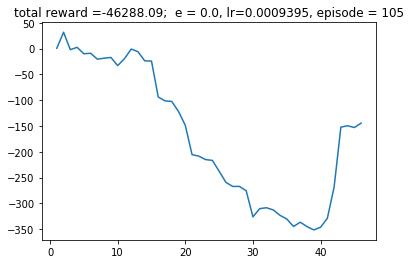

Waiting to train the whole dataset
action0:  92 
action1:  748 
action2:  1110
DONE, lets roll!!
351.45
More than 80 on candle 877
More than 80 on candle 1773


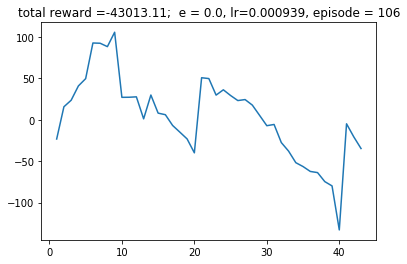

Waiting to train the whole dataset
action0:  102 
action1:  692 
action2:  1156
DONE, lets roll!!
321.457
More than 80 on candle 1800


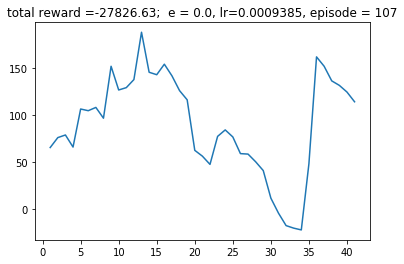

Waiting to train the whole dataset
action0:  69 
action1:  680 
action2:  1201
DONE, lets roll!!
339.127
More than 80 on candle 1848


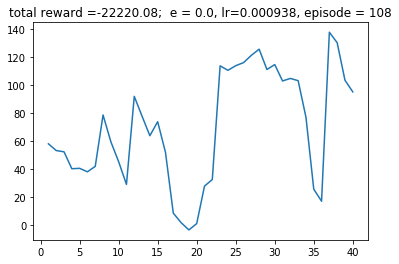

Waiting to train the whole dataset
action0:  55 
action1:  498 
action2:  1397
DONE, lets roll!!
353.685
More than 80 on candle 539
More than 80 on candle 1590
More than 80 on candle 1764


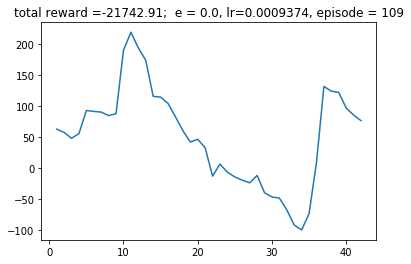

Waiting to train the whole dataset
action0:  71 
action1:  618 
action2:  1261
DONE, lets roll!!
349.331
More than 80 on candle 112
More than 80 on candle 1765


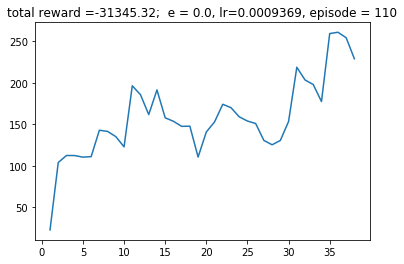

Waiting to train the whole dataset
action0:  82 
action1:  592 
action2:  1276
DONE, lets roll!!
346.815
More than 80 on candle 490
More than 80 on candle 1802


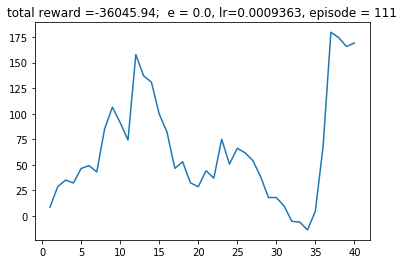

Waiting to train the whole dataset
action0:  97 
action1:  486 
action2:  1367
DONE, lets roll!!
352.997
More than 80 on candle 1852


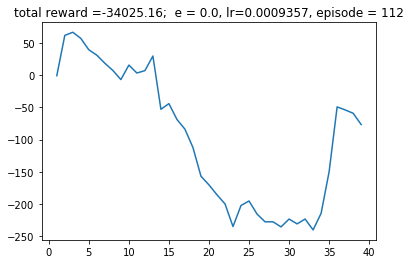

Waiting to train the whole dataset
action0:  75 
action1:  553 
action2:  1322
DONE, lets roll!!
348.929
More than 80 on candle 1856


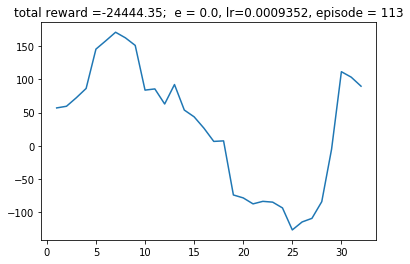

Waiting to train the whole dataset
action0:  62 
action1:  478 
action2:  1410
DONE, lets roll!!
354.259
More than 80 on candle 1855


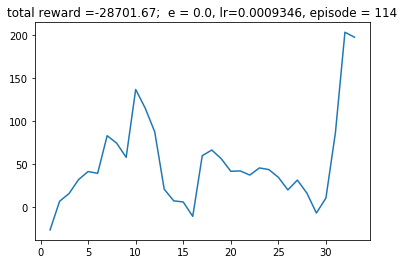

Waiting to train the whole dataset
action0:  73 
action1:  571 
action2:  1306
DONE, lets roll!!
350.587
More than 80 on candle 1845


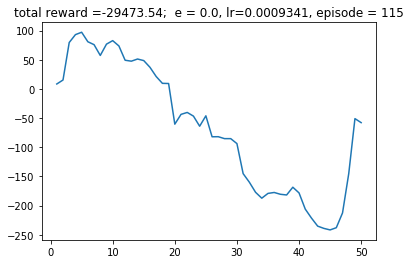

Waiting to train the whole dataset
action0:  61 
action1:  639 
action2:  1250
DONE, lets roll!!
351.578
More than 80 on candle 493
More than 80 on candle 1807


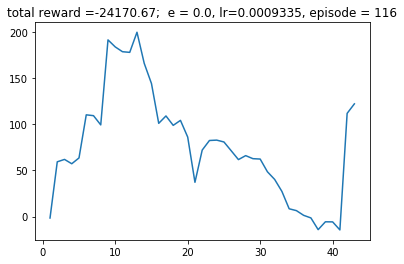

Waiting to train the whole dataset
action0:  64 
action1:  612 
action2:  1274
DONE, lets roll!!
352.728
More than 80 on candle 1836


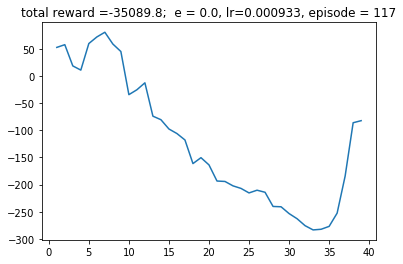

Waiting to train the whole dataset
action0:  80 
action1:  580 
action2:  1290
DONE, lets roll!!
352.185
More than 80 on candle 1857


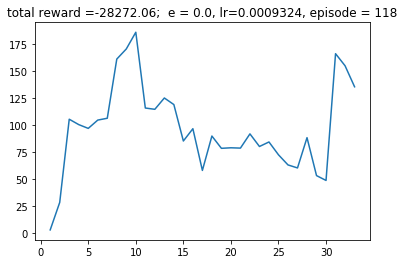

Waiting to train the whole dataset
action0:  59 
action1:  389 
action2:  1502
DONE, lets roll!!
418.562
More than 80 on candle 1822


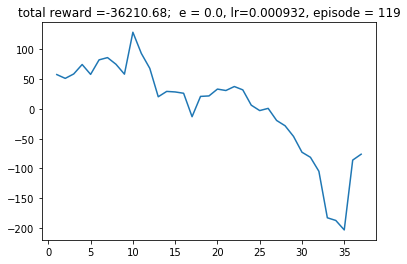

Waiting to train the whole dataset
action0:  74 
action1:  608 
action2:  1268
DONE, lets roll!!
324.381
More than 80 on candle 1790


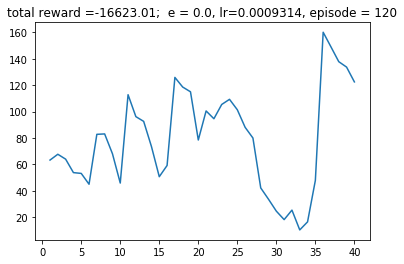

Waiting to train the whole dataset
action0:  44 
action1:  736 
action2:  1170
DONE, lets roll!!
341.989
More than 80 on candle 545
More than 80 on candle 1580
More than 80 on candle 1742


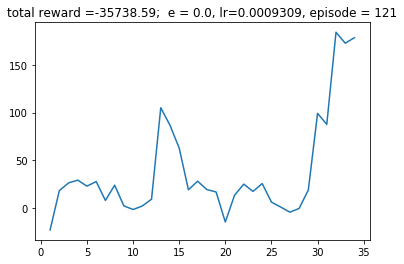

Waiting to train the whole dataset
action0:  88 
action1:  833 
action2:  1029
DONE, lets roll!!
344.093
More than 80 on candle 1860


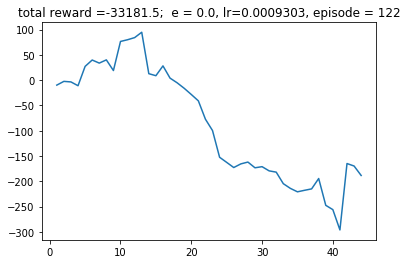

Waiting to train the whole dataset
action0:  67 
action1:  467 
action2:  1416
DONE, lets roll!!
350.065
More than 80 on candle 567
More than 80 on candle 1881


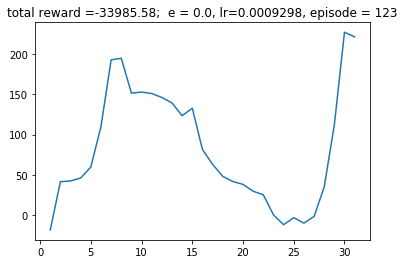

Waiting to train the whole dataset
action0:  88 
action1:  576 
action2:  1286
DONE, lets roll!!
352.86
More than 80 on candle 1855


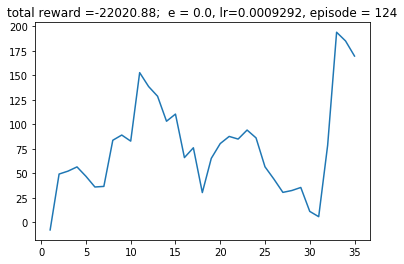

Waiting to train the whole dataset
action0:  58 
action1:  623 
action2:  1269
DONE, lets roll!!
351.965
More than 80 on candle 545
More than 80 on candle 1793


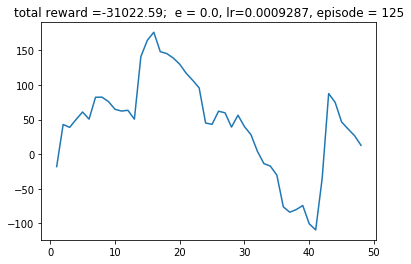

Waiting to train the whole dataset
action0:  84 
action1:  751 
action2:  1115
DONE, lets roll!!
354.233
More than 80 on candle 1847


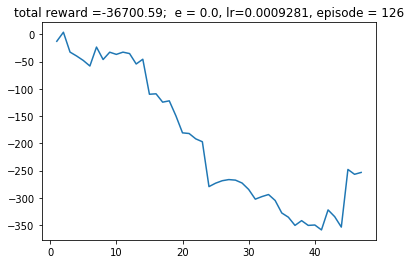

Waiting to train the whole dataset
action0:  60 
action1:  546 
action2:  1344
DONE, lets roll!!
352.815
More than 80 on candle 1855


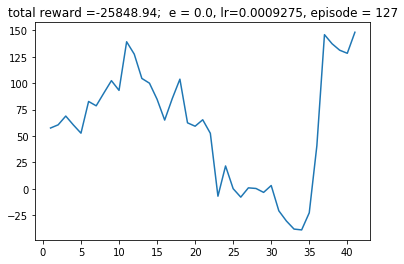

Waiting to train the whole dataset
action0:  66 
action1:  639 
action2:  1245
DONE, lets roll!!
355.325
More than 80 on candle 1795


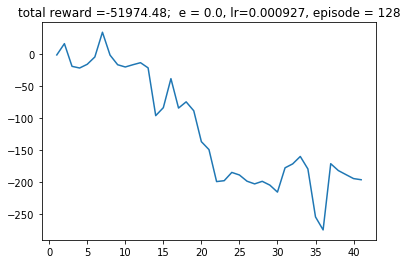

Waiting to train the whole dataset
action0:  104 
action1:  630 
action2:  1216
DONE, lets roll!!
354.359
More than 80 on candle 555
More than 80 on candle 1788


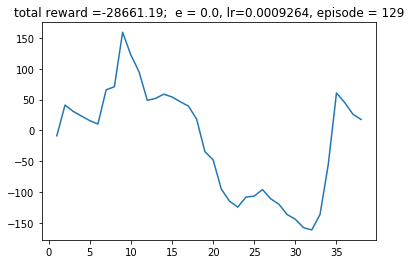

Waiting to train the whole dataset
action0:  77 
action1:  551 
action2:  1322
DONE, lets roll!!
356.748
More than 80 on candle 547
More than 80 on candle 1807


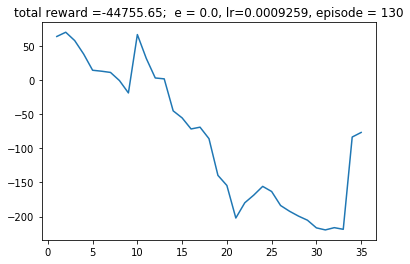

Waiting to train the whole dataset
action0:  102 
action1:  449 
action2:  1399
DONE, lets roll!!
349.942
More than 80 on candle 543
More than 80 on candle 1863


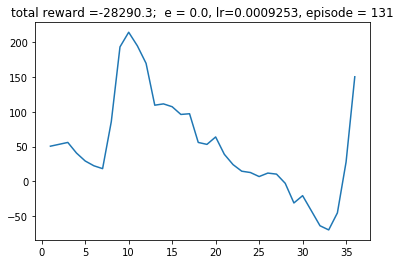

Waiting to train the whole dataset
action0:  82 
action1:  509 
action2:  1359
DONE, lets roll!!
351.901
More than 80 on candle 1809


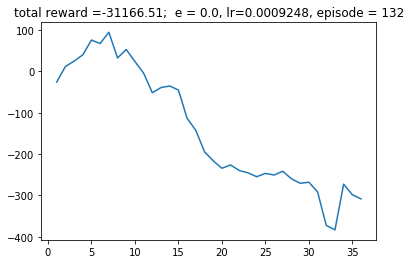

Waiting to train the whole dataset
action0:  48 
action1:  546 
action2:  1356
DONE, lets roll!!
350.836
More than 80 on candle 1874


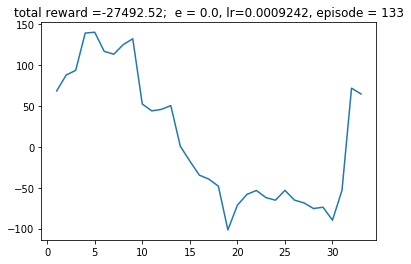

Waiting to train the whole dataset
action0:  65 
action1:  654 
action2:  1231
DONE, lets roll!!
351.618
More than 80 on candle 476
More than 80 on candle 1812


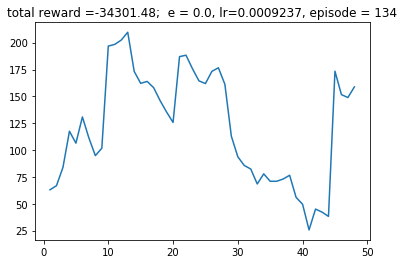

Waiting to train the whole dataset
action0:  93 
action1:  664 
action2:  1193
DONE, lets roll!!
349.634
More than 80 on candle 1850


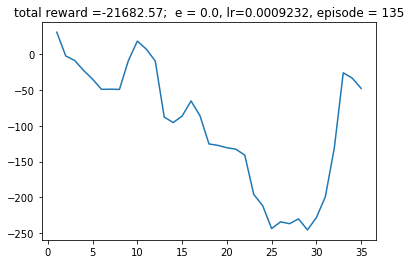

Waiting to train the whole dataset
action0:  42 
action1:  602 
action2:  1306
DONE, lets roll!!
350.61
More than 80 on candle 1802


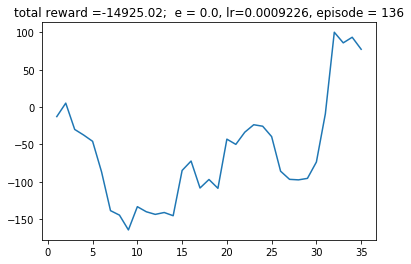

Waiting to train the whole dataset
action0:  39 
action1:  732 
action2:  1179
DONE, lets roll!!
347.988
More than 80 on candle 1797


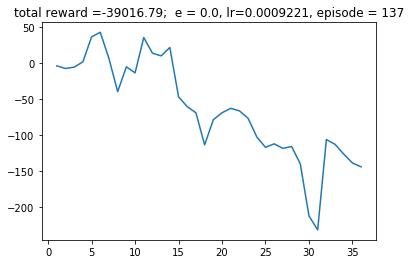

Waiting to train the whole dataset
action0:  78 
action1:  609 
action2:  1263
DONE, lets roll!!
354.533
More than 80 on candle 105
More than 80 on candle 492
More than 80 on candle 1791


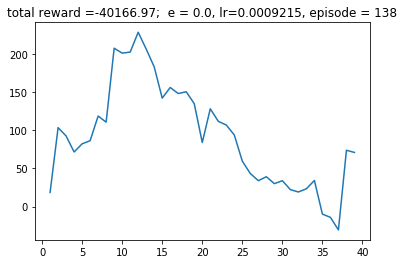

Waiting to train the whole dataset
action0:  99 
action1:  643 
action2:  1208
DONE, lets roll!!
354.896
More than 80 on candle 564
More than 80 on candle 1857


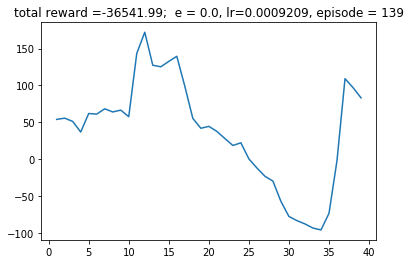

Waiting to train the whole dataset
action0:  91 
action1:  528 
action2:  1331
DONE, lets roll!!
361.425


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    akce0 = 0
    akce1 = 0
    akce2 = 0
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        if action == 0:
            akce0 += 1
        if action == 1:
            akce1 += 1
        if action == 2:
            akce2 += 1
        
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than 80 on candle {}'.format(time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    print("action0: ", akce0,"\naction1: ", akce1,"\naction2: ", akce2)
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))